# Aim

Get good and fast PSF fitting working, with the current models, in Python 3.8+. This could be using Theano, tf2+, or pytorch, and probably won't be using scipy.

1. (in the `oldeleanor` env) run code from master to show the baseline of fitting works
2. (in the `eleanorupgrade` env) set up frame-by-frame fitting in a new language, for sim data
3. the same as above for real data
4. set up all-at-once fitting using different weights for fluxes, and deviation-from-aperture regularization for coherence
5. the same as above for real data

In [1]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
import scipy.optimize as sopt
from scipy.special import iv
from zernike import RZern, FitZern
import torch
from torch.autograd import grad as tgrad
%load_ext autoreload
%autoreload 2

In [2]:
# first, step 1: surgically extract code from afeinstein20/eleanor/master that still operates with my new API
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=11, 
    width=11, 
    do_pca=True, 
    do_psf=False,
)
sources_in_tpf = eleanor.mast.gaia_sources_in_tpf(star, 10, tpfs.shape[1:])
xc = np.array(sources_in_tpf.coords_x) + tpfs.shape[2] / 2
yc = np.array(sources_in_tpf.coords_y) + tpfs.shape[1] / 2
x, y = np.meshgrid(range(-58, 59), range(-58, 59)) 

In [5]:
data.psf_lightcurve(data_arr=tpfs, err_arr=errs, bkg_arr=bkgs, verbose=True, bkg_mag_cutoff=10, ignore_pixels=1)


100%|██████████| 900/900 [03:17<00:00,  4.55it/s]


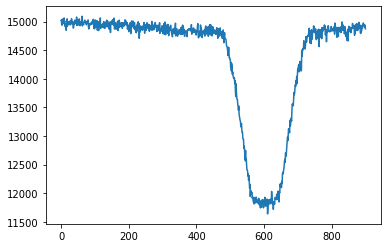

In [6]:
plt.plot(data.psf_flux[:,1])

In [10]:
lk.estimate_cdpp(data.psf_flux[:,1]).value

2143.5424115116416

In [13]:
np.mean(data.psf_params, axis=0)

array([ 0.68399225, -0.0294704 ,  0.74843862])

In [6]:
prf = eleanor.make_prf_from_source(star)

In [24]:
def gaussian(pars):
    amp, a, b, c, bkg = pars
    psf = amp * np.exp(-(a * x ** 2 + 2 * b * x * y + c * y ** 2)) + bkg
    return psf / np.sum(psf)

def moffat(pars):
    amp, a, b, c, beta, bkg = pars
    psf = amp / (1 + x ** 2 / a ** 2 + 2 * b * x * y + y ** 2 / c ** 2) ** beta + bkg
    return psf
    # return psf / np.sum(psf)

def airy(pars):
    # doesn't work yet
    amp, Rn, bkg = pars
    bessel_arg = np.pi * np.sqrt(x ** 2 + y ** 2) / Rn
    return amp * (2 * iv(1, bessel_arg) / bessel_arg) ** 2

def get_loss(model, prf):
    return lambda pars: np.sum((model(pars) - prf) ** 2)

In [25]:
loss = get_loss(gaussian, prf)
res = sopt.minimize(loss, [1., 1, 0.1, 1, 0], tol=1e-4)
res

      fun: nan
 hess_inv: array([[ 9.60886358e-01,  1.04134506e+00, -2.32937062e-01,
         1.03720699e+00,  5.10200538e-04],
       [ 1.04134506e+00,  3.95820171e+00, -1.79499023e-02,
         2.93132564e+00,  1.80540221e-03],
       [-2.32937062e-01, -1.79499023e-02,  8.53425184e-01,
        -1.42775539e-02, -1.07928775e-04],
       [ 1.03720699e+00,  2.93132564e+00, -1.42775539e-02,
         3.90460961e+00,  1.79138848e-03],
       [ 5.10200538e-04,  1.80540221e-03, -1.07928775e-04,
         1.79138848e-03,  1.00589488e-06]])
      jac: array([nan, nan, nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 756
      nit: 4
     njev: 126
   status: 2
  success: False
        x: array([-4.27659854e+02, -8.76597963e+02, -7.04285617e+01, -8.66814530e+02,
       -4.95472587e-01])

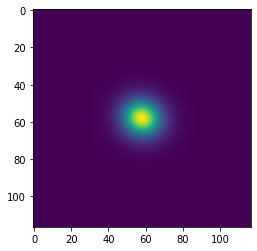

In [14]:
plt.imshow(moffat(res.x))

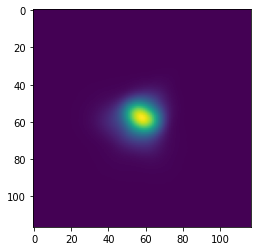

In [15]:
plt.imshow(prf)

Text(0.5, 1.0, '0.07943378197888844')

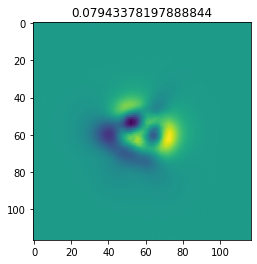

In [16]:
plt.imshow(moffat(res.x) - prf)
plt.title(loss(res.x))

In [100]:
pol = RZern(6)
L, K = 117, 117
ip = FitZern(pol, L, K)
pol.make_pol_grid(ip.rho_j, ip.theta_i)

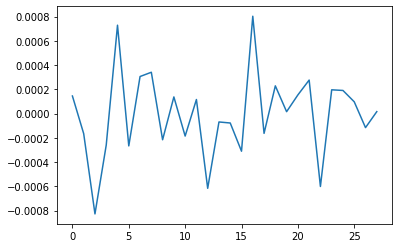

In [458]:
coeffs = ip.fit((moffat(res.x) - prf).flatten())
plt.plot(coeffs)

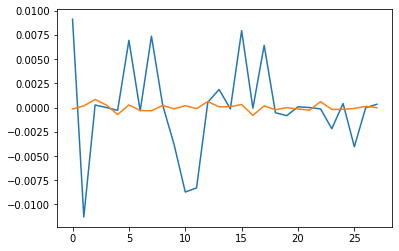

In [459]:
plt.plot(ip.fit(moffat(res.x).flatten()))
plt.plot(ip.fit(prf.flatten()) - ip.fit(moffat(res.x).flatten()))


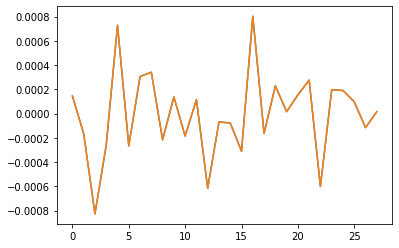

In [461]:
plt.plot(-ip.fit(prf.flatten()) + ip.fit(moffat(res.x).flatten()))
plt.plot(ip.fit((moffat(res.x) - prf).flatten()))

In [462]:
res.x

array([ 2.16540198e-01,  1.14321911e-01, -9.90395712e-04,  1.22320234e-01,
        1.73031536e+00, -5.00081924e-04])

In [29]:
psf_model.bounds[:,0]

array([ 0. , -2. , -2. ,  0. ,  0. , -0.5,  0. ,  0. ])

In [567]:
call_model = lambda x: psf_model(x[0], 58, 58, x[1:])
loss = lambda p: np.sum((call_model(p).numpy() - prf)**2)

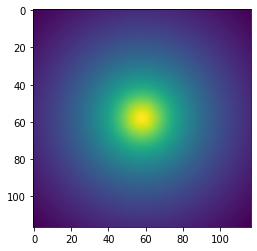

In [568]:
plt.imshow(call_model(np.concatenate(([1], 1/9 * psf_model.get_default_optpars()))))

In [611]:
sopt.minimize(loss, np.concatenate(([10], 1/9 * psf_model.get_default_optpars())), method='TNC', tol=1e-4)

     fun: 2.5784518003168446
     jac: array([-0.07210267, -3.67316617, -0.13826349,  4.56976137, -0.84809054])
 message: 'Max. number of function evaluations reached'
    nfev: 606
     nit: 6
  status: 3
 success: False
       x: array([ 3.50569498e+01,  1.37036410e-01, -4.89957699e-03,  2.56472469e-01,
        1.32287200e+00])

In [54]:
psf_model = eleanor.models.Gaussian(
    shape=(117,117),
    col_ref=0,
    row_ref=0,
    xc=[58],
    yc=[58],
    bkg0=0
)

(array(8.50111672), array([ 1.76980095e+00, -3.83332796e-04,  9.05129296e-03, -1.55715515e+02,
        2.76875748e-02,  4.16605993e-03,  2.64051597e-02]))
(array(8.5011144), array([ 1.76980104e+00, -3.83332796e-04,  9.05129295e-03, -1.55715107e+02,
        2.76875285e-02,  4.16605992e-03,  2.64051134e-02]))
(array(8.50111672), array([ 1.76980094e+00, -3.83332796e-04,  9.05129295e-03, -1.55715515e+02,
        2.76875752e-02,  4.16605992e-03,  2.64051601e-02]))
(array(8.50111672), array([ 1.76980095e+00, -3.83332796e-04,  9.05129296e-03, -1.55715515e+02,
        2.76875748e-02,  4.16605993e-03,  2.64051597e-02]))
(array(8.20481763), array([ 3.50400298e+57,  0.00000000e+00,  0.00000000e+00, -1.35736648e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00]))
(array(8.20481763), array([ 3.50400298e+57,  0.00000000e+00,  0.00000000e+00, -1.35736648e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00]))
(array(8.20481763), array([ 3.50400298e+57,  0.00000000e+00,  0.0000000

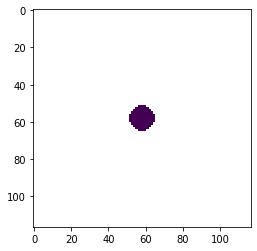

In [65]:
par0_prf = psf_model.get_default_par([1])
nll = lambda psf_val: torch.sum((psf_val - torch.tensor(prf)) ** 2)

def loss_and_grad_fn(params):
    params = np.maximum(psf_model.bounds[:,0], np.minimum(psf_model.bounds[:,1], params))
    params = torch.tensor(params, requires_grad=True)
    flux = params[0]
    shifts = params[1:3]
    bkg = params[3]
    optpars = params[4:]
    mean_val = psf_model(flux, 58+shifts[0], 58+shifts[1], optpars, False) + bkg
    if torch.isnan(mean_val).any():
        print("nan")
        return np.array([1e+20]), -np.ones_like(params)
    #funcval = gaussian(np.concatenate(([flux.detach().numpy()], optpars.detach().numpy(), [0])))
    #max_dev = (np.max(np.abs(mean_val.detach().numpy() - funcval)))
    
    #if (np.isnan(max_dev) or (max_dev > 1)):
    #    p = optpars.detach().numpy()
    #    is_posdef = np.sqrt(p[0] * p[2]) > p[1] ** 2
     #   print(max_dev, optpars.detach().numpy(), is_posdef)
    loss = nll(mean_val)
    gradient = tgrad(loss, params)
    return loss.detach().numpy(), gradient[0].detach().numpy()

res_prf = sopt.minimize(lambda x: print(loss_and_grad_fn(x)) or loss_and_grad_fn(x), par0_prf, jac=True, method='TNC', tol=1e-4)
plt.imshow(psf_model(res_prf.x[0], 58+res_prf.x[1], 58+res_prf.x[2], res_prf.x[4:]) + res_prf.x[3])

In [14]:
pol.rhotab

NameError: name 'pol' is not defined

In [86]:
def twoD_Gaussian(coords, A, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = np.cos(theta) ** 2/(2 * sigma_x**2) + np.sin(theta) ** 2 /(2 * sigma_y**2)
    b = np.sin(2 * theta) * (1 / sigma_y ** 2 - 1 / sigma_x ** 2) / 4
    c = np.sin(theta) ** 2/(2 * sigma_x**2) + np.cos(theta) ** 2 /(2 * sigma_y**2)
    dx, dy = coords[0] - xo, coords[1] - yo
    g = offset + A*np.exp(-(a * dx ** 2 - 2 * b * dx * dy + c * dy ** 2))
    return g.ravel()

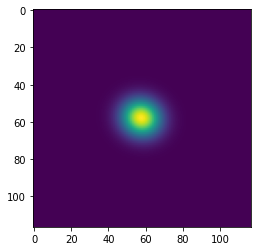

In [96]:
popt, pcov = sopt.curve_fit(twoD_Gaussian, (x, y), prf.ravel(), p0=(1,0,0,1,1,0,0))
plt.imshow(twoD_Gaussian((x, y), *popt).reshape(117,117))

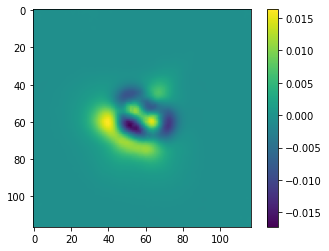

In [98]:
plt.imshow(prf - twoD_Gaussian((x, y), *popt).reshape(117,117))
plt.colorbar()

In [94]:
popt

array([ 2.28378397e-01, -3.73802642e-01, -9.67755497e-02,  6.75075362e+00,
        7.37166347e+00,  8.21169730e+00,  7.00639197e-04])

In [95]:
nll(torch.tensor(twoD_Gaussian((x, y), *popt).reshape(117,117)))

tensor(0.0867, dtype=torch.float64)

In [41]:
par0_prf = psf_model.get_default_par([0])
par0_prf.shape

(8,)

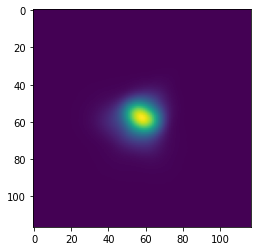

In [613]:
plt.imshow(prf)

In [604]:
moffat_test_pars = np.array([1, 0.28615548, -0.25894334, 0.65728192, 0.82289539, 0])

In [610]:
psf_model(1, 58, 58, moffat_test_pars[1:5], False)

tensor([[   nan, 0.2401, 0.1022,  ..., 0.0041, 0.0040, 0.0040],
        [   nan,    nan, 0.2380,  ..., 0.0041, 0.0041, 0.0041],
        [   nan,    nan,    nan,  ..., 0.0042, 0.0042, 0.0041],
        ...,
        [0.0041, 0.0042, 0.0042,  ...,    nan,    nan,    nan],
        [0.0041, 0.0041, 0.0041,  ..., 0.2380,    nan,    nan],
        [0.0040, 0.0040, 0.0041,  ..., 0.1022, 0.2401,    nan]],
       dtype=torch.float64)

In [608]:
moffat(moffat_test_pars)

array([[       nan, 0.17658706, 0.06258769, ..., 0.00124359, 0.00123187,
        0.00122033],
       [       nan,        nan, 0.17477332, ..., 0.00126783, 0.00125576,
        0.00124389],
       [       nan,        nan,        nan, ..., 0.00129287, 0.00128042,
        0.0012682 ],
       ...,
       [0.0012682 , 0.00128042, 0.00129287, ...,        nan,        nan,
               nan],
       [0.00124389, 0.00125576, 0.00126783, ..., 0.17477332,        nan,
               nan],
       [0.00122033, 0.00123187, 0.00124359, ..., 0.06258769, 0.17658706,
               nan]])

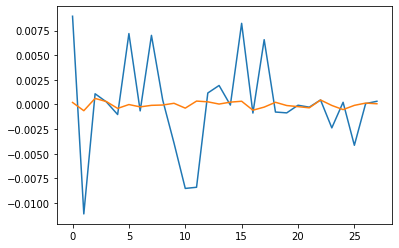

In [104]:
plt.plot(ip.fit(prf.flatten()))
plt.plot(ip.fit(prf.flatten() - twoD_Gaussian((x, y), *popt)))

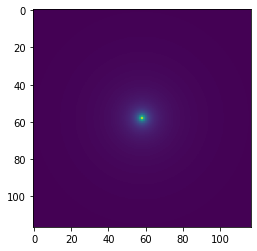

In [576]:
 par0_prf = np.concatenate(([10], 1/9 * psf_model.get_default_optpars()))
 nll = lambda psf_val: np.sum((psf_val - prf) ** 2)
 def loss_fn(params):
    flux = params[0]
    optpars = params[1:]
    mean_val = psf_model(flux, 58, 58, optpars, False).detach().numpy()
    loss = nll(mean_val)
    return loss

loss_fn(par0_prf)
res_prf = sopt.minimize(loss_fn, par0_prf)
plt.imshow(psf_model(res_prf.x[0], 58, 58, res_prf.x[1:]))

In [575]:
torch.max(torch.abs(psf_model(1, 58, 58, [1, 0, 1, 1], False) - moffat([1, 1, 0, 1, 1, 0])))

tensor(0., dtype=torch.float64)

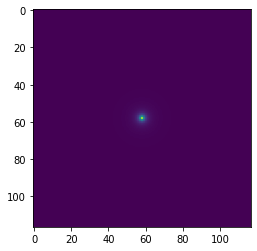

In [552]:
plt.imshow()

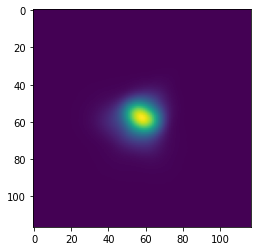

In [528]:
plt.imshow(prf)

In [16]:
torch

<module 'torch' from '/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/torch/__init__.py'>

In [17]:
coeffs = np.random.normal(0, 1, 10)

In [25]:
from functools import reduce

In [21]:
x = torch.tensor(1., requires_grad=True)


tensor(-0.5573, grad_fn=<AddBackward0>)

In [29]:
torch.autograd.grad(reduce(lambda c, r: c * x + r, coeffs), x)

(tensor(-0.7211),)

In [41]:
zern = eleanor.models.RZern(6)

In [43]:
xx, yy = np.meshgrid(np.linspace(-1, 1, 23), np.linspace(-1, 1, 23))

In [61]:
c0 = np.random.normal(size=zern.nk)


In [86]:
c_test = np.zeros(shape=zern.nk)
c_test[3] = 1

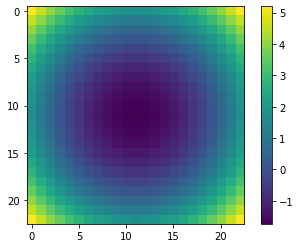

In [106]:
zern.make_cart_grid(xx, yy, unit_circle=False)
Phi1 = zern.eval_grid(c_test, matrix=True)
zern.make_cart_grid(xx+0.5, yy-0.5, unit_circle=False)
Phi2 = zern.eval_grid(c_test, matrix=True)
plt.imshow(Phi1)
plt.colorbar()

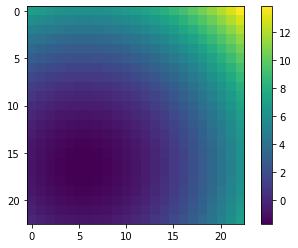

In [107]:
plt.imshow(Phi2)
plt.colorbar()

In [108]:
zern.make_cart_grid(xx, yy, unit_circle=False)


In [109]:
np.linalg.lstsq(zern.ZZ, Phi2.flatten())

(array([ 1.73205081e+00, -1.73205081e+00,  1.73205081e+00,  1.00000000e+00,
         1.10861060e-15, -5.48393596e-16,  3.92981741e-16, -1.35674611e-16,
         1.26155563e-15,  1.23197449e-15,  7.90294768e-16,  2.98771742e-16,
         1.69268230e-15,  5.11841970e-16,  5.74305246e-16,  5.77378454e-16,
        -5.00365592e-16, -4.59073590e-16,  6.74421105e-16,  7.75358037e-16,
        -1.81210827e-15, -2.22044605e-15, -9.88751191e-16, -2.69087008e-16,
         2.55720115e-16, -2.22044605e-16, -2.47499664e-15, -1.90522189e-16]),
 array([1.09164232e-27]),
 28,
 array([707.19150176, 707.06185766, 318.59513816, 318.59513816,
        141.45327606, 139.99864667,  75.04999129,  75.04999129,
         53.18555528,  46.78504098,  43.31826215,  41.97211664,
         34.66927845,  34.66927845,  33.64782994,  29.59327515,
         29.59327515,  24.13334533,  23.68006102,  21.16245853,
         21.16245853,  20.76183588,  19.94716135,  19.93925232,
         19.57981445,  19.57981445,  19.53768587,  

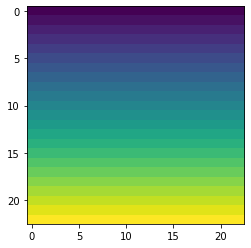

In [111]:
plt.imshow(zern.ZZ[:,1].reshape(23,23))

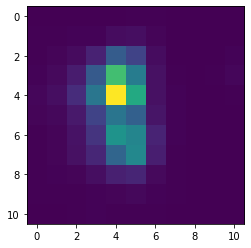

In [115]:
plt.imshow(tpfs[0])